# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Описание данных
Данные находятся в файле `/datasets/autos.csv`\
**Признаки**\
`DateCrawled` — дата скачивания анкеты из базы\
`VehicleType` — тип автомобильного кузова\
`RegistrationYear` — год регистрации автомобиля\
`Gearbox` — тип коробки передач\
`Power` — мощность (л. с.)\
`Model` — модель автомобиля\
`Kilometer` — пробег (км)\
`RegistrationMonth` — месяц регистрации автомобиля\
`FuelType` — тип топлива\
`Brand` — марка автомобиля\
`Repaired` — была машина в ремонте или нет\
`DateCreated` — дата создания анкеты\
`NumberOfPictures` — количество фотографий автомобиля\
`PostalCode` — почтовый индекс владельца анкеты (пользователя)\
`LastSeen` — дата последней активности пользователя\
**Целевой признак**\
`Price` — цена (евро)

### Ход работы 
- Загрузите данные, путь к файлу: `/datasets/autos.csv`.
- Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
- Подготовьте выборки для обучения моделей.
- Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
- Проанализируйте время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

## Подготовка данных

In [1]:
!pip install phik
!pip install missingno 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error 

from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

import phik
import missingno as msno

In [3]:
df = pd.read_csv('/datasets/autos.csv')

In [4]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df
df = optimize_memory_usage(df)

Размер использования памяти: до 43.26 Mb - после 29.74 Mb (31.2%)


In [5]:
df.head() 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
# Преобразуем типы данных
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['LastSeen'] = pd.to_datetime(df['LastSeen'])

In [7]:
df.info() #Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int16         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int16         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int16         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int32         
 8   RegistrationMonth  354369 non-null  int8          
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int8    

In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [9]:
#Займёмся обработкой аномальных значений, таких как 1000 год или нулевая цена
df = df[(df['Price']>=10) & (df['RegistrationYear']>=1900) & (df['RegistrationYear']<=2016) & (df['Power']!=0)] 
df = df.drop(['NumberOfPictures', 'DateCrawled','DateCreated', 'RegistrationMonth', 'PostalCode', 'LastSeen'], axis = 1) #Удалим неинформативные признаки

Столбец `NumberOfPictures` был удалён, т.к. все значения в нём нули, остальные столбцы были удалены, т.к. цена машины не зависит от того, в каком месяце было создано объявление, когда последний раз заходил пользователь, когда была скачена анкета и создано объявление

In [10]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,296218.000000,296218.000000,296218.000000,296218.000000
mean,4864.253016,2002.821263,124.269973,128252.891452
std,4610.881173,6.552150,190.930894,36797.992868
min,10.000000,1910.000000,1.000000,5000.000000
25%,1350.000000,1999.000000,75.000000,125000.000000
50%,3200.000000,2003.000000,111.000000,150000.000000
75%,6999.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,20000.000000,150000.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296218 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             296218 non-null  int16 
 1   VehicleType       285270 non-null  object
 2   RegistrationYear  296218 non-null  int16 
 3   Gearbox           290865 non-null  object
 4   Power             296218 non-null  int16 
 5   Model             285058 non-null  object
 6   Kilometer         296218 non-null  int32 
 7   FuelType          280724 non-null  object
 8   Brand             296218 non-null  object
 9   Repaired          253384 non-null  object
dtypes: int16(3), int32(1), object(6)
memory usage: 18.6+ MB


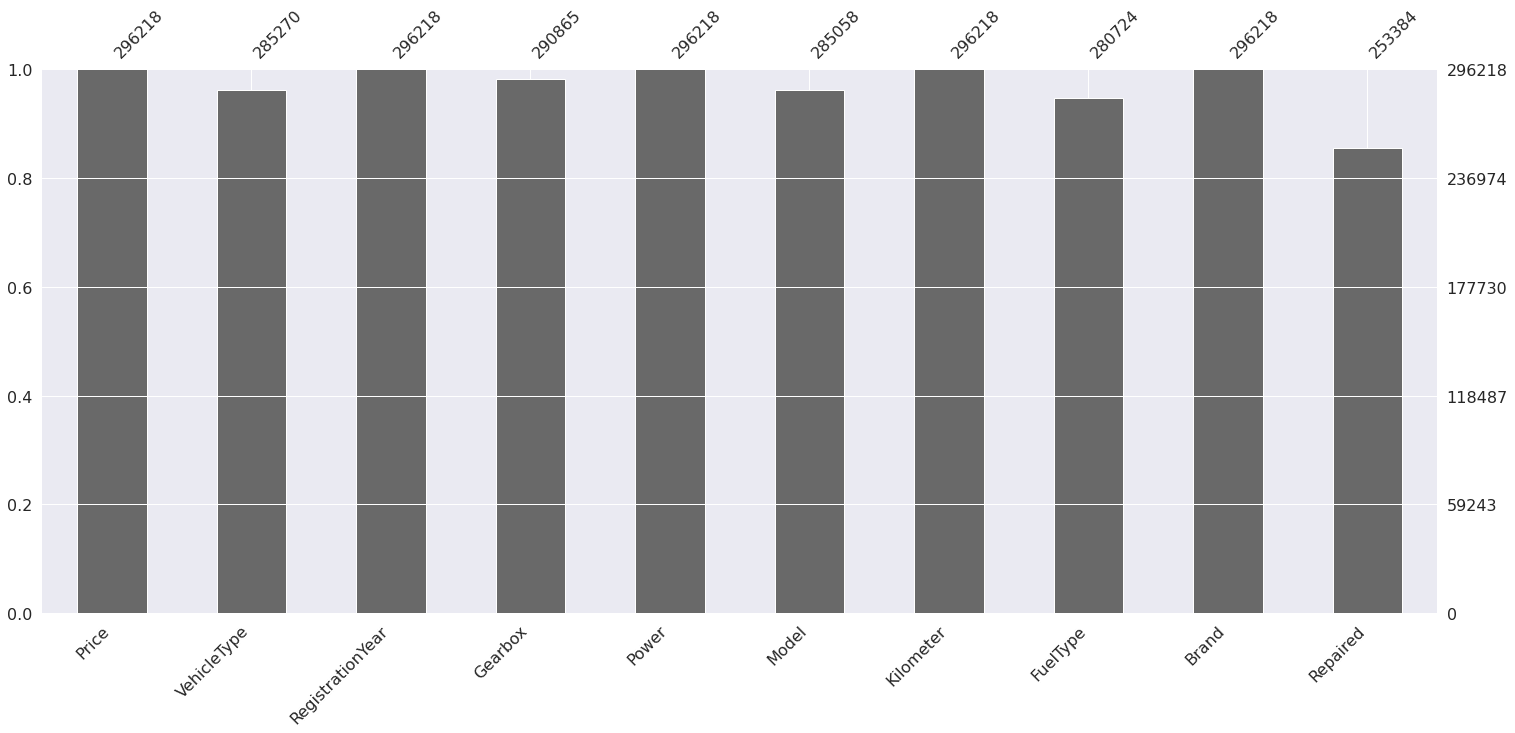

In [12]:
sns.set()
msno.bar(df);

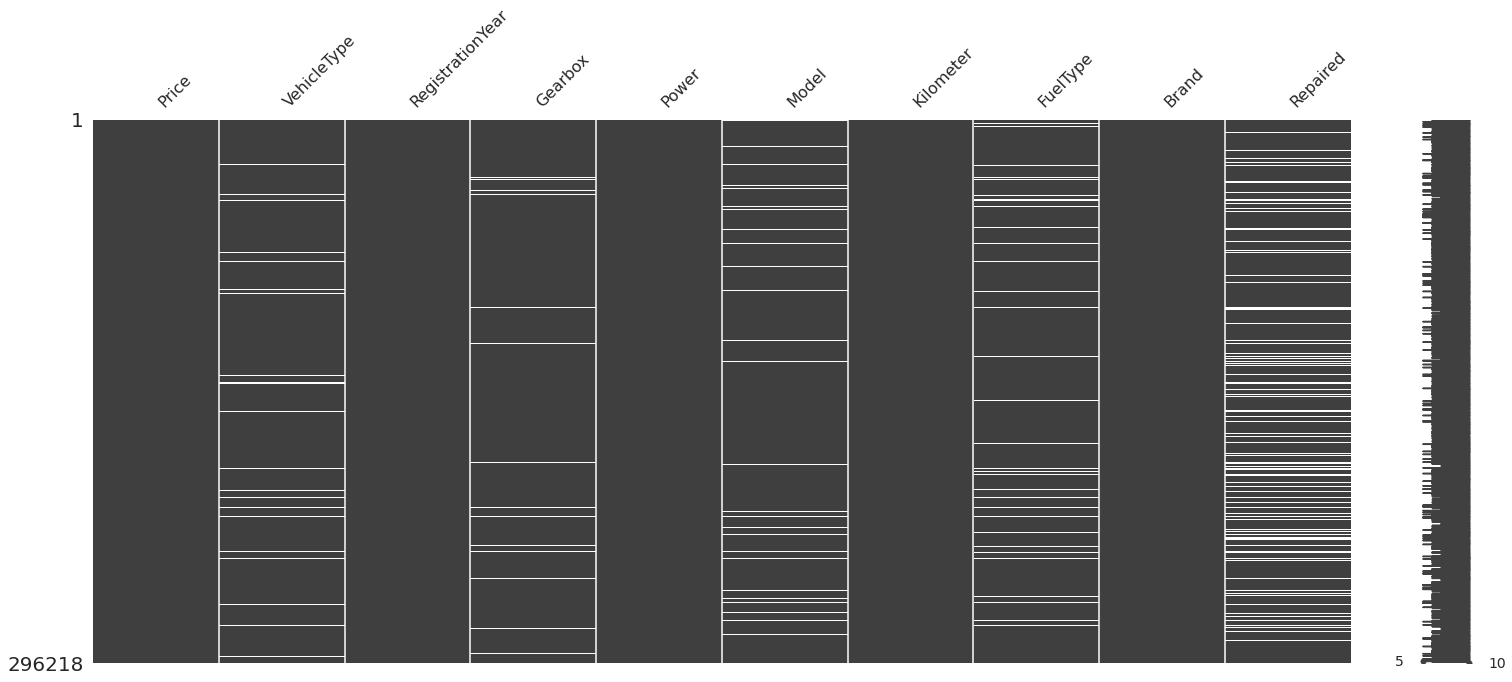

In [13]:
msno.matrix(df);

In [14]:
df = df.fillna('Unknown') #Пропуски только в категориальных столбцах и их количество слишком велико, чтобы удалять, так что заполним их значением Unknown

In [15]:
df.phik_matrix(interval_cols=['Price', 'Power', 'Kilometer']).style.background_gradient(cmap ='coolwarm')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.000000,0.274475,0.681359,0.292763,0.006193,0.578497,0.313855,0.263221,0.363349,0.336682
VehicleType,0.274475,1.000000,0.643568,0.383012,0.012898,0.901111,0.251443,0.395823,0.591275,0.327427
RegistrationYear,0.681359,0.643568,1.000000,0.203107,0.022394,0.662412,0.639149,0.423443,0.394743,0.344088
Gearbox,0.292763,0.383012,0.203107,1.000000,0.012290,0.627022,0.056038,0.215213,0.521889,0.269284
Power,0.006193,0.012898,0.022394,0.012290,1.000000,0.000000,0.015995,0.018255,0.000000,0.018671
Model,0.578497,0.901111,0.662412,0.627022,0.000000,1.000000,0.441940,0.545232,0.997996,0.269132
Kilometer,0.313855,0.251443,0.639149,0.056038,0.015995,0.441940,1.000000,0.153692,0.276183,0.226341
FuelType,0.263221,0.395823,0.423443,0.215213,0.018255,0.545232,0.153692,1.000000,0.333760,0.198398
Brand,0.363349,0.591275,0.394743,0.521889,0.000000,0.997996,0.276183,0.333760,1.000000,0.132673
Repaired,0.336682,0.327427,0.344088,0.269284,0.018671,0.269132,0.226341,0.198398,0.132673,1.000000


In [16]:
#У столбцов Brand и Model - коллинеарность практически 1, удалим один из них для удаления мультиколлинеарности
df = df.drop('Brand', axis=1)

In [17]:
df.loc[df['FuelType']=='gasoline', 'FuelType']='petrol'

In [18]:
df = df.drop_duplicates()

В рамках этого этапа была проведена предобработка данных: обработаны пропущенные значения, удалены дубликаты, неинформативные столбцы и обработаны аномалии.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256316 entries, 1 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             256316 non-null  int16 
 1   VehicleType       256316 non-null  object
 2   RegistrationYear  256316 non-null  int16 
 3   Gearbox           256316 non-null  object
 4   Power             256316 non-null  int16 
 5   Model             256316 non-null  object
 6   Kilometer         256316 non-null  int32 
 7   FuelType          256316 non-null  object
 8   Repaired          256316 non-null  object
dtypes: int16(3), int32(1), object(5)
memory usage: 14.2+ MB


## Обучение моделей

In [20]:
ohe_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType']
ord_columns = ['Repaired']
num_columns = ['RegistrationYear', 'Power', 'Kilometer']
RANDOM_STATE = 42

y = df['Price']
X = df.drop(['Price'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE
) 

In [21]:
ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OrdinalEncoder(handle_unknown='ignore')
        )
    ]
) 

In [22]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['yes', 'Unknown', 'no']
                ], 
                handle_unknown='ignore'
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [23]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns)
    ], 
    remainder='passthrough'
) 

In [24]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

Будем искать лучшие гиперпараметры для различных моделей

In [25]:
param_distributions = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(5, 20)],
        'models__min_samples_split': range(2, 15)
    }
] 

In [26]:
randomized_search = RandomizedSearchCV( #Дерево
    pipe_final, 
    param_distributions, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OrdinalEncoder(handle_unknown='ignore'))]),
                                                                               ['VehicleType',
                                                                                'Gearbox',
                                                                                'Model',
                                                                                'FuelType']),
                                                                              ('ord',
                                                                 

In [27]:
randomized_search.best_score_*-1 #Значение метрики меньше, чем 2500

1956.8342409651134

In [28]:
pipe_final_2= Pipeline([
    ('models', LGBMRegressor(random_state=RANDOM_STATE))
])

In [29]:
param_distributions_2 = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 500],
        'models__max_depth': [3, 5, 7, 10]
    }
] 

In [30]:
for i in ohe_columns:
    X_train[i] = X_train[i].astype('category')
for i in ord_columns:
    X_train[i] = X_train[i].astype('category')    

/tmp/ipykernel_490/3808021381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i] = X_train[i].astype('category')
/tmp/ipykernel_490/3808021381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i] = X_train[i].astype('category')


In [31]:
randomized_search_2 = RandomizedSearchCV( #LGBMRegressor
    pipe_final_2, 
    param_distributions_2, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_2.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('models',
                                              LGBMRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LGBMRegressor(max_depth=10,
                                                                  n_estimators=500,
                                                                  random_state=42)],
                                         'models__max_depth': [3, 5, 7, 10],
                                         'models__n_estimators': [100, 200,
                                                                  500]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [32]:
randomized_search_2.best_score_*-1 #Значение метрики меньше, чем 2500

1627.178390561464

Были обучены две модели, решающие задачи регрессии: LGBMRegressor и DecisionTreeRegressor. У обоих значения метрик RSME меньше 2500, как и требуется по условию.

## Анализ моделей

In [33]:
randomized_search.best_estimator_ #Лучшие гиперпараметры для дерева. Теперь замерим время обучения и предсказания

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OrdinalEncoder(handle_unknown='ignore'))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['yes',
                                                                             

In [34]:
model_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeRegressor(max_depth=16, min_samples_split=12, random_state=42))
])

In [35]:
%%timeit
model_tree.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.

617 ms ± 5.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%%timeit
tree_predict = model_tree.predict(X_test)

78.9 ms ± 619 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
tree_predict = model_tree.predict(X_test)

In [38]:
mean_squared_error(y_test, tree_predict, squared=False) #Значение метрики меньше чем 2500

1923.514918694816

In [39]:
randomized_search_2.best_estimator_ #Лучшие гиперпараметры для бустинга. Теперь замерим время обучения и предсказания

Pipeline(steps=[('models',
                 LGBMRegressor(max_depth=10, n_estimators=500,
                               random_state=42))])

In [40]:
for i in ohe_columns:
    X_test[i] = X_test[i].astype('category')
for i in ord_columns:
    X_test[i] = X_test[i].astype('category')  

/tmp/ipykernel_490/3941439585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[i] = X_test[i].astype('category')
/tmp/ipykernel_490/3941439585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[i] = X_test[i].astype('category')


In [41]:
model_lgbm = Pipeline([
    ('model', LGBMRegressor(max_depth=10,n_estimators=500, random_state=42))
])

In [42]:
%%timeit
model_lgbm.fit(X_train, y_train)

13 s ± 362 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
%%timeit
model_lgbm.predict(X_test)

2.76 s ± 39.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
boost_predict = model_lgbm.predict(X_test)
mean_squared_error(y_test, boost_predict, squared=False) #Значение метрики меньше чем 2500

1610.8410313152774

Подведём итоги:\
***Модель LightGBM***\
Время обучения: 13 секунд, предсказания: 2.8 с, RMSE: 1610\
***Модель DecisionTreeRegressor***\
Время обучения: 617 мс, предсказания: 80 мс, RMSE: 1923\
\
Бустинг обучается сильно дольше, но и точность предсказания у этой модели выше, так что использовал бы я именно бустинг, ведь время всё ещё не сильно значительное (12 секунд)


## Выводы


Надо было построить модель, которая умеет определять цену автомобиля. В моём распоряжении были данные о технических характеристиках, комплектации и ценах других автомобилей.\
Для решения данной задачи сначала была проведена предобработка данных: удалении пропусков, обработка аномалий и дубликатов.\
Далее, используя пайплайны, данные были подготовлены и найдены лучшие гиперпараметры для двух моделей: DecisionTreeRegressor и LightGBM. Для них далее были проведены замеры времени обучения и предсказания.\

***Модель LightGBM***\
Время обучения: 13 секунд, предсказания: 2.8 с, RMSE: 1610\
***Модель DecisionTreeRegressor***\
Время обучения: 617 мс, предсказания: 80 мс, RMSE: 1923\
\
Бустинг обучается сильно дольше, но и точность предсказания у этой модели выше, так что использовал бы я именно бустинг, ведь время всё ещё не сильно значительное (12 секунд)
